### Graph Neural Network (GNN)

$$h_{i}^{t+1} = f\left(h_{i}^{t} W + \sum_{j \in N (i)} \frac{1}{C_{i,j}} h_{j}^{t} U \right)$$

Old representation times a weight matrix:
$$h_{i}^{t} W $$

Information from neighbors times a weight matrix:
$$h_{j}^{t} U $$

### Aggregation function:

Sum over all transformed neighbor representations

$$\sum_{j \in N (i)} \frac{1}{C_{i,j}}$$

Normalize the vectors differently for each neighbor
$$\frac{1}{C_{i,j}}$$

The sum is a $permutation-invariant$ aggregation function -> Insensitive to $order$

Each node's updated value becomes a weighting of its previous value+weightning of it's neighbors values.

-> Agg function can be mean, max, concatenation, etc.



Collapse $W_{self}$ and $W_{neigh}$ into $W$ by adding self-loops to the adjacency matrix $A$:
$$H^{(k+1)} = \sigma \left( (A+I)H^{(k)} W^{k+1} \right)$$

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Linear
import torch_geometric.transforms as T
from torch_geometric.utils import to_undirected
from torchviz import make_dot

import networkx as nx
from networkx.classes.function import density, degree

import csv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 360

### Graph dataset
<div style="text-align:center; display: flex; justify-content: center;">
  <table>
    <tr>
      <th>Rosette number</th>
      <th>Nodes</th>
      <th>Edges</th>
    </tr>
    <tr>
      <td>3</td>
      <td>11157</td>
      <td>7572</td>
    </tr>
    <tr>
      <td>6</td>
      <td>9568</td>
      <td>5245</td>
    </tr>
    <tr>
      <td>7</td>
      <td>11635</td>
      <td>9257</td>
    </tr>
    <tr>
      <td>11</td>
      <td>13667</td>
      <td>13051</td>
    </tr>
    <tr>
      <td>12</td>
      <td>10617</td>
      <td>6870</td>
    </tr>
    <tr>
      <td>13</td>
      <td>13260</td>
      <td>14395</td>
    </tr>
    <tr>
      <td>14</td>
      <td>10704</td>
      <td>7635</td>
    </tr>
    <tr>
      <td>15</td>
      <td>10131</td>
      <td>8655</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11117</td>
      <td>7991</td>
    </tr>
    <tr>
      <td>19</td>
      <td>10248</td>
      <td>6689</td>
    </tr>
  </table>
</div>



In [9]:
def graph_r(r):

    nodes = []
    edges = []
    mass = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)
                mass.append(float(values[1]))

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges.append([float(n) for n in list(row.values())])

    return (nodes,edges,mass)

In [10]:
rosettes = [3,6,7,11,12,13,14,15,18,19]
props = ['log flux_g','log flux_r','log flux_z','log flux_w1','log flux_w2','z']

In [11]:
nodes, edges, mass = graph_r(rosettes[0])
graph = nx.Graph()
for i in range(len(nodes)):
    node = nodes[i]
    graph.add_node(i, attr=node[1:])

id_to_position = {node[0]: i for i, node in enumerate(nodes)}
mapped_edges = [[id_to_position[edge[0]], id_to_position[edge[1]], edge[2]] for edge in edges]
for edge in mapped_edges:
    graph.add_edge(edge[0], edge[1], weight=edge[2])

In [12]:
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')
print(f'Directed: {graph.is_directed()}')
print(f'Multigraph: {graph.is_multigraph()}')
print(f'Mean degree: {np.mean(np.array(degree(graph))[:,1])}')
print(f'Max degree: {max(np.array(degree(graph))[:,1])}')
print(f'Min degree: {min(np.array(degree(graph))[:,1])}')
print(f'Density: {density(graph)}')

Number of nodes: 11157
Number of edges: 7059
Directed: False
Multigraph: False
Mean degree: 1.2653939230976068
Max degree: 14
Min degree: 0
Density: 0.00011342720716185074


In [13]:
edge_index = torch.tensor(list(graph.edges), dtype=torch.float).t().contiguous()
edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float)
x = torch.tensor([graph.nodes[i]['attr'] for i in range(len(graph.nodes))], dtype=torch.float)
mass = torch.tensor(mass, dtype=torch.float)

num_nodes = len(nodes)
train_percentage = 0.8
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
num_train_nodes = int(num_nodes*train_percentage)
train_mask[:num_train_nodes] = True
test_mask = ~train_mask

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=mass, train_mask=train_mask, test_mask=test_mask)

In [14]:
graph

Data(x=[11157, 6], edge_index=[2, 7059], edge_attr=[7059], y=[11157], train_mask=[11157], test_mask=[11157])

In [15]:
nodes, edges, mass = graph_r(rosettes[0])
id_to_position = {node[0]: i for i, node in enumerate(nodes)}
mapped_edges = [[id_to_position[edge[0]], id_to_position[edge[1]], edge[2]] for edge in edges]

nodes = torch.tensor(np.array(nodes)[:,1:], dtype=torch.float)
mass = torch.tensor(mass, dtype=torch.float)
edges_at = torch.tensor(np.array(mapped_edges)[:,2], dtype=torch.float)
edges = torch.tensor(mapped_edges, dtype=torch.long)[:, :2].t().contiguous()

num_nodes = nodes.size(0)
train_percentage = 0.8
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
num_train_nodes = int(num_nodes*train_percentage)
train_mask[:num_train_nodes] = True
test_mask = ~train_mask

graph = Data(x=nodes, edge_index=edges, edge_attr=edges_at, y=mass, train_mask=train_mask, test_mask=test_mask)
graph.num_nodes = nodes.size(0)
graph.num_edges = edges.size(1)

In [16]:
from networkx.readwrite import json_graph
json_data = json_graph.node_link_data(graph)
json_data

AttributeError: 'GlobalStorage' object has no attribute 'is_multigraph'

### GNN Model

In [ ]:

class GNN(nn.Module):
    def __init__(self, hidden_channels, task='node'):
        super(GNN, self).__init__()
        torch.manual_seed(26)

        self.conv1 = GCNConv(graph.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, 1)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.out(x)

        return x

In [ ]:
model = GNN(hidden_channels=16)
print(model)
print(f'Parameters: {sum(p.numel() for p in model.parameters())}')

GNN(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(16, 1, bias=True)
)
Parameters: 401


In [ ]:
make_dot(model(graph.x, graph.edge_index), params=dict(list(model.named_parameters()))).render("./torchviz/gnn_torchviz", format="png")

'torchviz/gnn_torchviz.png'

Move to GPU (if available)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
graph = graph.to(device)

Optimizer: Stochastic gradient descent

Loss function: Mean squared error

In [ ]:
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.MSELoss()

### Training

In [ ]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(graph.x, graph.edge_index)
      loss = criterion(out[graph.train_mask].view(-1), graph.y[graph.train_mask])
      loss.backward()
      optimizer.step()
      return loss

losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    loss = train()
    losses.append(loss)
    if (epoch%100==0):
      print(f'Epoch: {epoch}, mse: {loss:.4f}')

Epoch: 0, mse: 0.3738
Epoch: 100, mse: 0.3738
Epoch: 200, mse: 0.3738
Epoch: 300, mse: 0.3738
Epoch: 400, mse: 0.3738
Epoch: 500, mse: 0.3738
Epoch: 600, mse: 0.3738
Epoch: 700, mse: 0.3738
Epoch: 800, mse: 0.3738
Epoch: 900, mse: 0.3738


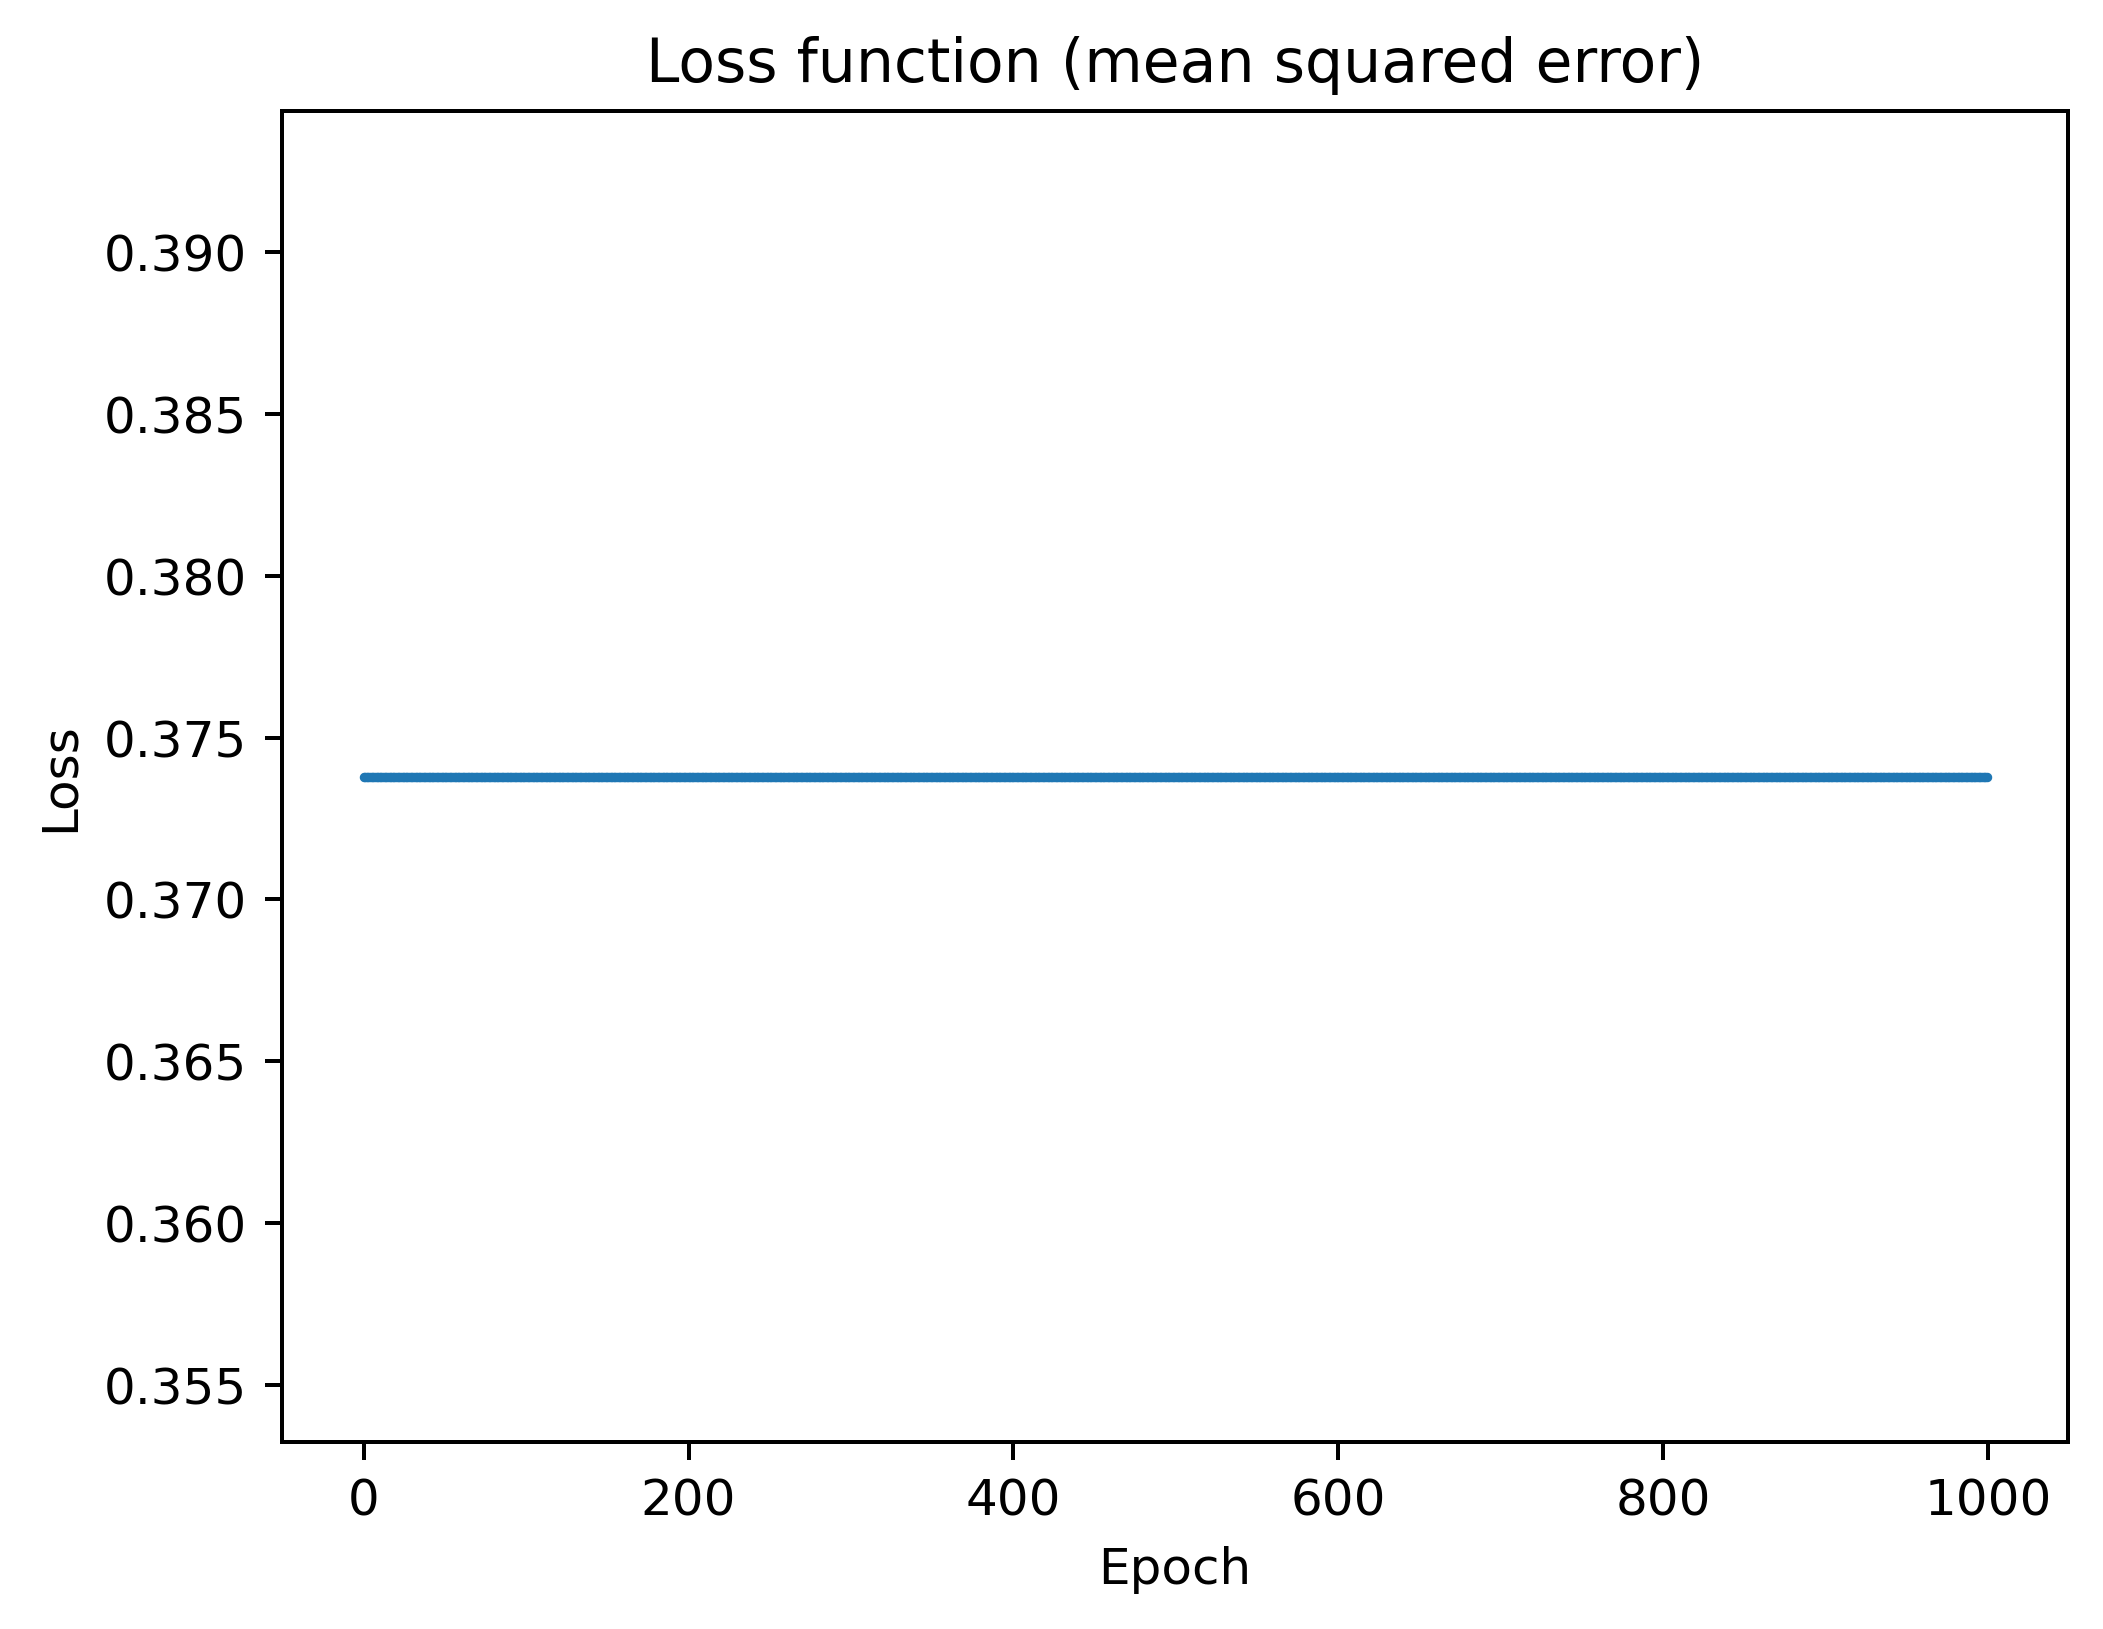

In [ ]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt.scatter(loss_indices, losses_float, s=0.8)
plt.title('Loss function (mean squared error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Testing

In [ ]:
def test():
      model.eval()
      out = model(graph.x, graph.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[graph.test_mask]==graph.y[graph.test_mask]
      test_acc = int(test_correct.sum())/int(graph.test_mask.sum())
      return test_acc, pred

test_acc, prediction = test()
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.0000


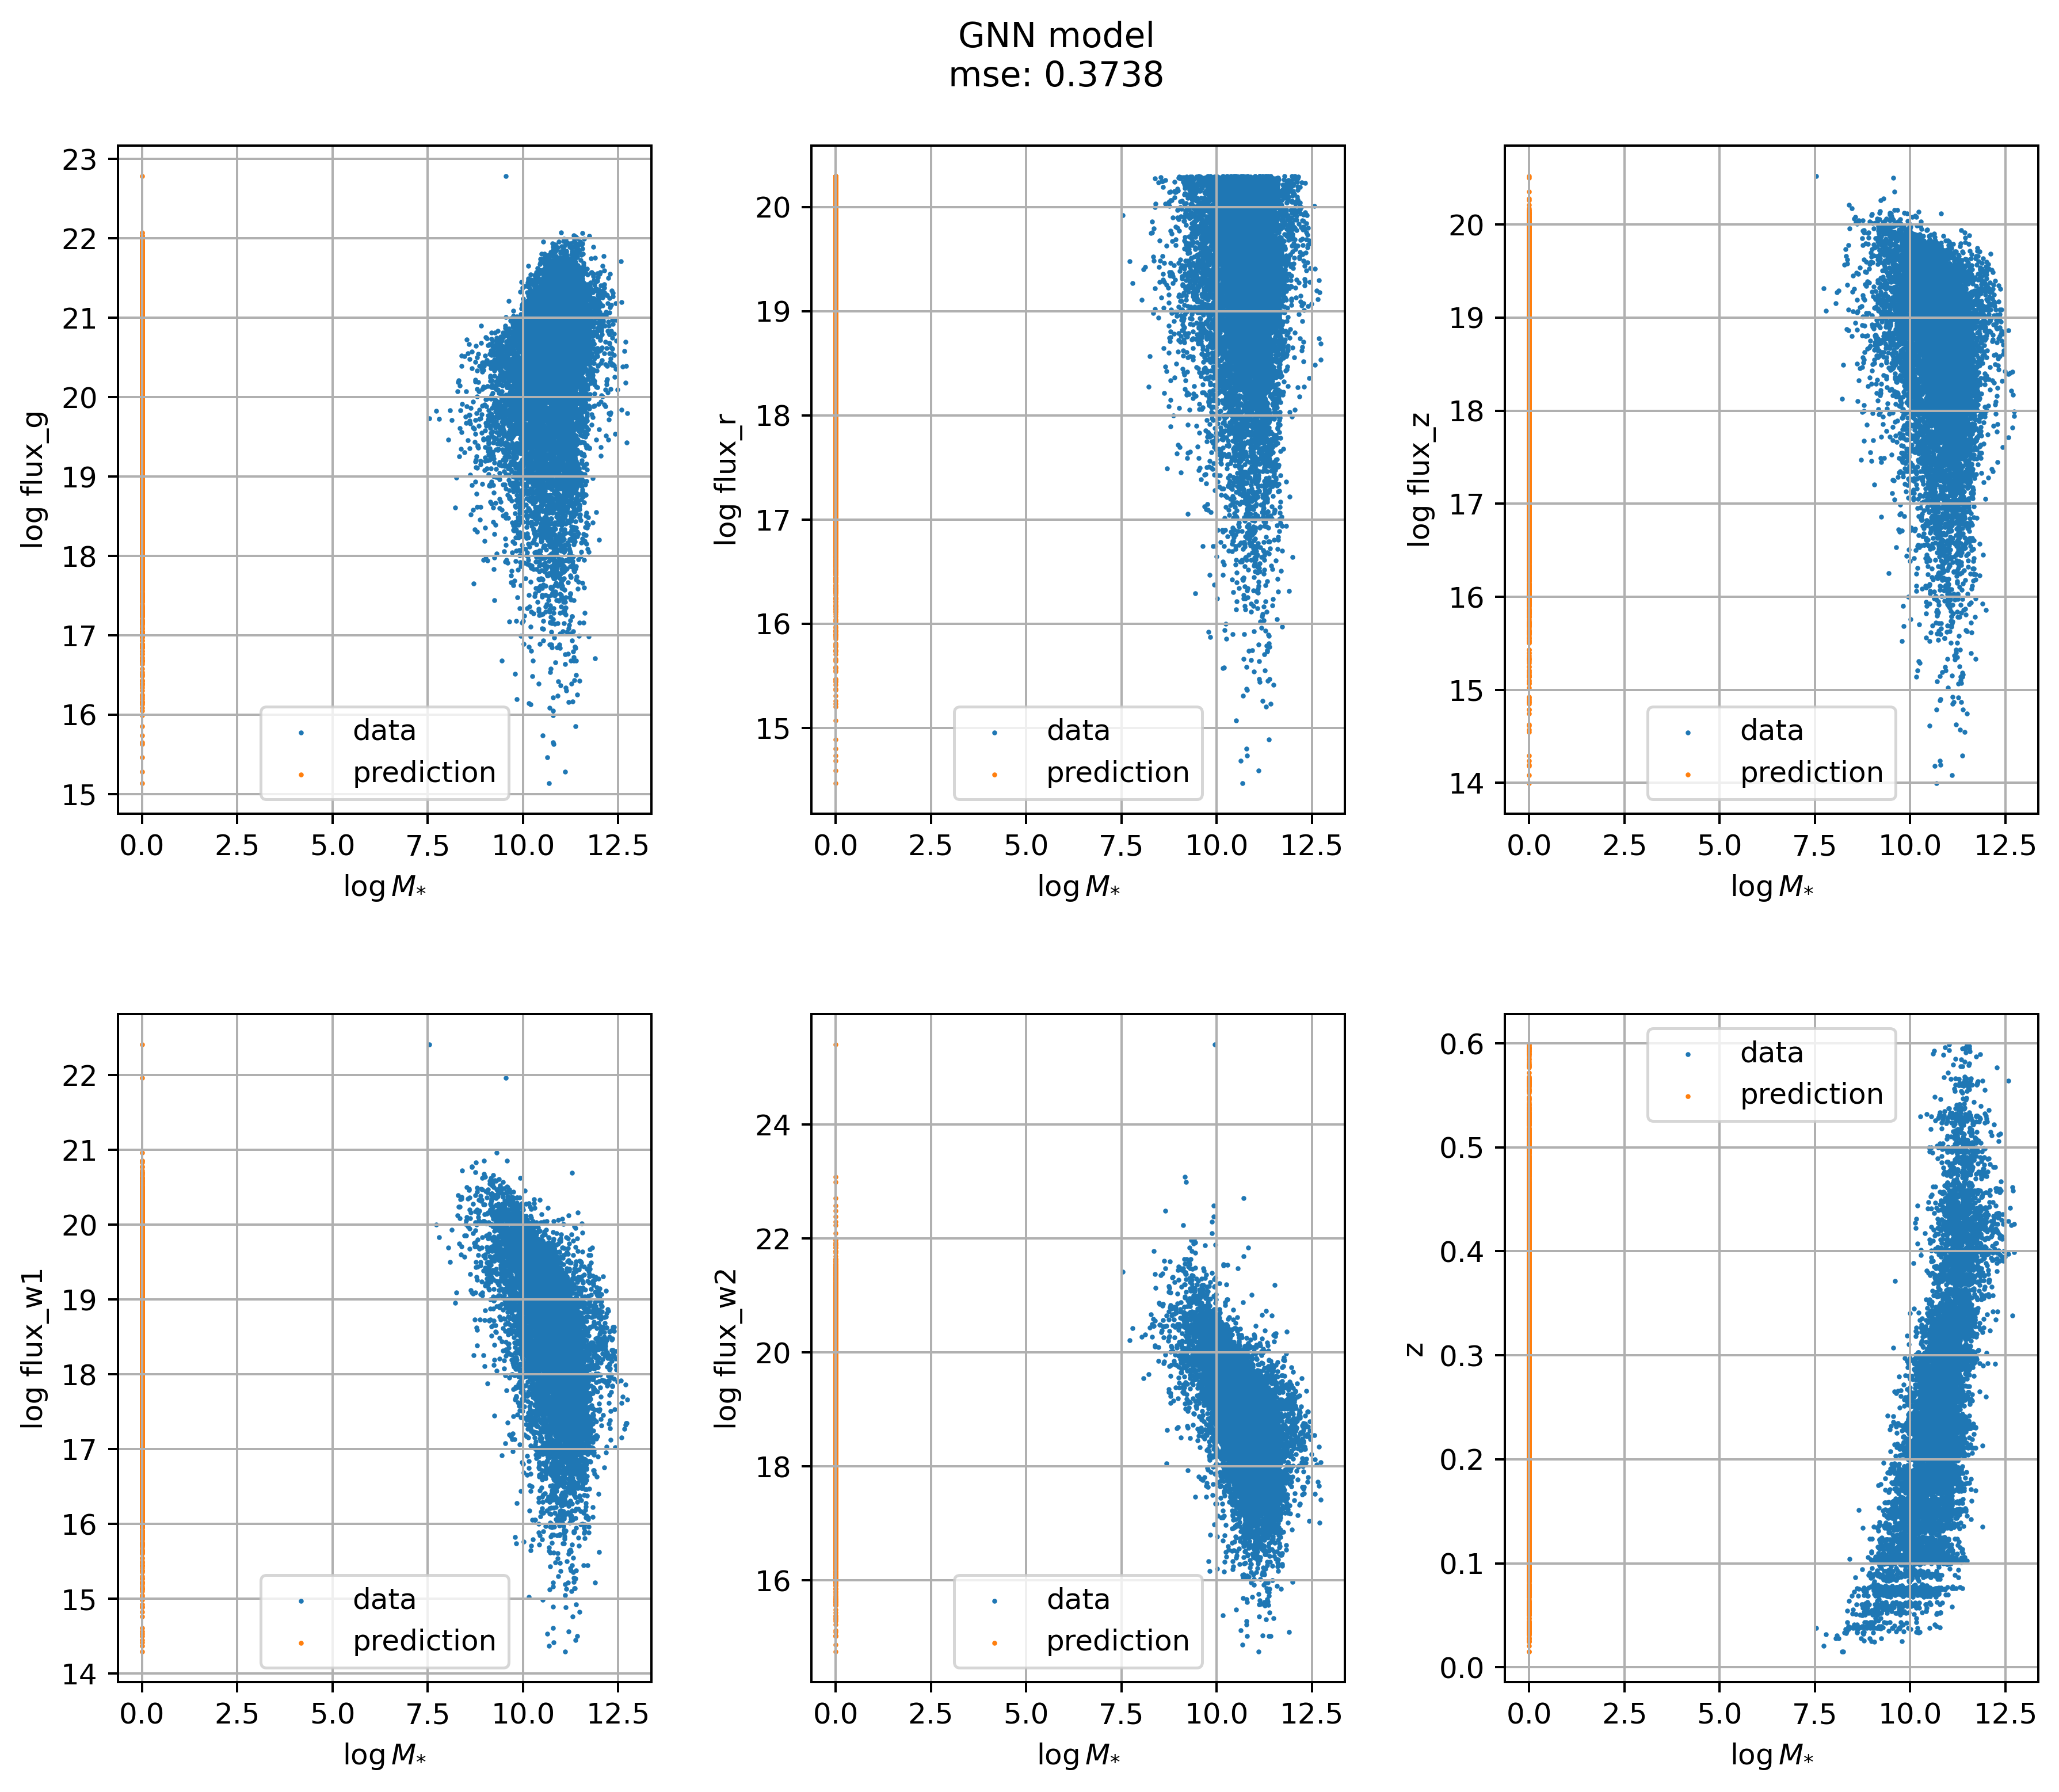

In [ ]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(f'GNN model\nmse: {loss:.4f}', y=1.05)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

nodes, _, mass = graph_r(rosettes[0])
nodes, mass, pred = np.array(nodes)[:,1:], np.array(mass), prediction.numpy()

for i in range(ncols):
    for j in range(nrows):
        axes[i, j].scatter(mass, nodes[:,i*3+j], s=0.5, label='data')
        axes[i, j].scatter(pred, nodes[:,i*3+j], s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'{props[i*3+j]}')
        axes[i, j].grid()

plt.show()